# SOM Visualization and Provenance

**GitHub Repository**: [https://github.com/Jean-BaptisteCellier/SOM_TopographicProduct.git](https://github.com/Jean-BaptisteCellier/SOM_TopographicProduct.git)  
**License**: Apache License  
**Description**: This repository contains Python code for SOM visualization of the topographic product and provenance generation.

In [1]:
import numpy as np
import pandas as pdcoding
import gzip

In [2]:
#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse
idata = SOMToolBox_Parse("iris\\iris.vec").read_weight_file()
weights = SOMToolBox_Parse("iris\\iris.wgt.gz").read_weight_file()

In [6]:
#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
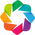

:Layout
   .Image.HitHist               :Image   [x,y]   (z)
   .Image.U_hyphen_minus_Matrix :Image   [x,y]   (z)
   .Image.SDH                   :Image   [x,y]   (z)

In [7]:
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

hithist = hv.Image(HitHist(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None) 
um = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) 
sdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)   

hv.Layout([hithist.relabel('HitHist').opts(cmap='kr'), 
           um.relabel('U-Matrix').opts(cmap='jet'), sdh.relabel('SDH').opts(cmap='viridis')])

We are using:\
• Euclidean distance in input space\
• Manhattan distance in output space

### Data processing

• Compute pairwise distances in input space\
• Determine the best-matching units for all input vectors, as well as their positions in the SOM grid\
• Compute the pairwise SOM distances 

In [6]:
from sklearn.metrics.pairwise import euclidean_distances

idata_arr = idata['arr']
weights_arr = weights['arr']
som_xdim, som_ydim = weights['xdim'], weights['ydim']

# Pairwise distances in input space
input_distances = np.linalg.norm(idata_arr[:, np.newaxis] - idata_arr, axis=2)

# Best-matching units for input vectors
# bmus = np.argmin(np.linalg.norm(idata_arr[:, np.newaxis] - weights_arr.reshape(-1, 4), axis=2), axis=1)
# # Pairwise SOM distances (Manhattan distance)
# grid_positions = np.array([[i, j] for i in range(som_xdim) for j in range(som_ydim)])
# bmu_positions = grid_positions[bmus]
# som_distances = np.abs(bmu_positions[:, np.newaxis] - bmu_positions).sum(axis=2)

grid_positions = np.array([[i, j] for i in range(som_xdim) for j in range(som_ydim)])
som_distances = np.abs(grid_positions[:, np.newaxis] - grid_positions).sum(axis=2)

weights_distances = euclidean_distances(weights_arr)

In [7]:
def get_kth_neighbor(unit_i, all_distances, k):
    distances = all_distances[unit_i]
    
    nonzero_distances = distances[distances > 0]
    unique_distances = np.unique(nonzero_distances)

    if len(unique_distances) < k:
        raise ValueError(f"Not enough neighbors: k={k} but only {len(unique_distances)} unique distances available.")
    
    kth_unique_distance = unique_distances[k - 1]
    kth_neighbor_indices = np.where(distances == kth_unique_distance)
    
    mean_kth_distance = np.mean(distances[kth_neighbor_indices])
    
    return kth_neighbor_indices, mean_kth_distance

### $P_{1}$: Distortion in input space

**Comparison of distances between weights of neighboring units (input space)**

**Purpose:** Measures how well the topological relationships in the input space are preserved in the SOM. If two input vectors are close in the original input space, their corresponding BMUs should also reflect this closeness in the output space.

\begin{equation*}
    P_{1}(j,k) = \Bigl(\prod_{l=1}^{k} Q_{1}(j,l) \Bigl)^{1/k}
\end{equation*}
where
\begin{equation*}
Q_{1}(j,l) = \frac{d^{I}(\mathbf{w}_{j}, \mathbf{w}_{n_{k}^{O}(j)})}{d^{I}(\mathbf{w}_{j}, \mathbf{w}_{n_{k}^{I}(j)})}
\end{equation*}
$j$: reference unit\
$l$: "order" of the neighborhod

In [8]:
def distortion_input_space(som_distances, weights_distances, unit_i, max_k):
    p1 = 1.0  # Initialize the distortion product

    for k in range(1, max_k + 1):
        # Distance based on neighbors in SOM grid
        som_k_neighbors, _ = get_kth_neighbor(unit_i, som_distances, k)
        input_dist_output_neighbors = np.mean([weights_distances[unit_i, neighbor] for neighbor in som_k_neighbors])

        # Distance based on neighbors in input space
        _, input_dist_input_neighbors = get_kth_neighbor(unit_i, weights_distances, k)

        # Compute Q1 for this k-th neighborhood
        q1 = input_dist_output_neighbors / input_dist_input_neighbors
        p1 *= q1

    # Final distortion
    p1 = p1 ** (1 / max_k)

    return p1

In [9]:
list_disto_input_2 =[]
list_disto_input_3 = []
list_disto_input_4 = []

for i in range(100):
    list_disto_input_2.append(distortion_input_space(i, 2))
    list_disto_input_3.append(distortion_input_space(i, 3))
    list_disto_input_4.append(distortion_input_space(i, 4))

Text(0.5, 1.0, 'Distortion product with several k')

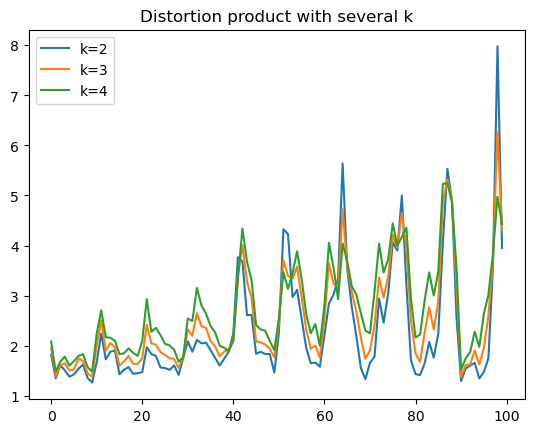

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(100), list_disto_input_2, label="k=2")
plt.plot(range(100), list_disto_input_3, label="k=3")
plt.plot(range(100), list_disto_input_4, label="k=4")
plt.legend()
plt.title("Distortion product with several k")

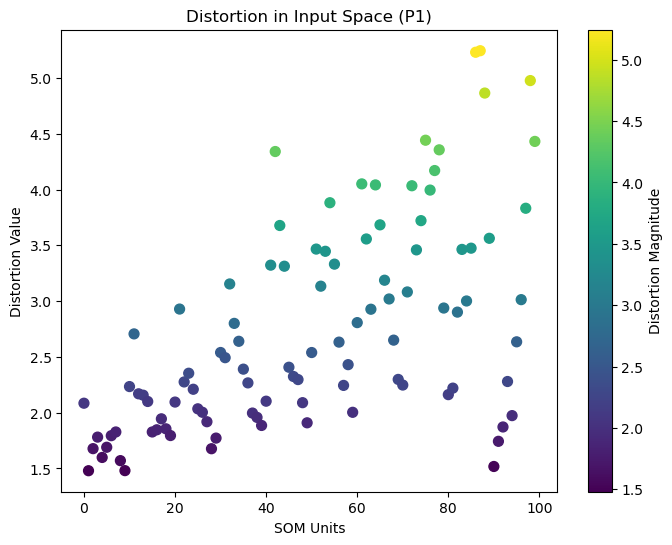

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(list_disto_input_4)), list_disto_input_4, c=list_disto_input_4, cmap='viridis', s=50)
plt.colorbar(label='Distortion Magnitude')
plt.title('Distortion in Input Space (P1)')
plt.xlabel('SOM Units')
plt.ylabel('Distortion Value')
plt.show()

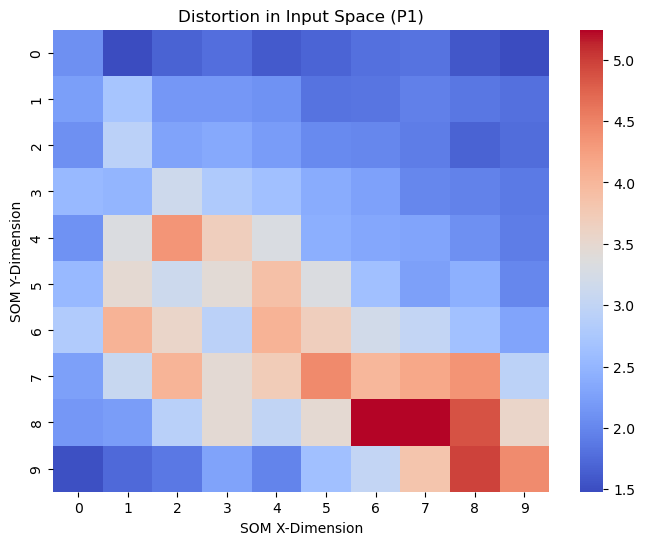

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

disto_input_4 = np.array(list_disto_input_4)
disto_input_4 = disto_input_4.reshape(som_xdim, som_ydim)

plt.figure(figsize=(8, 6))
sns.heatmap(disto_input_4, cmap='coolwarm', annot=False)
plt.title('Distortion in Input Space (P1)')
plt.xlabel('SOM X-Dimension')
plt.ylabel('SOM Y-Dimension')
plt.show()

### $P_{2}$: Distortion in output space

**Comparison of distances between SOM units in the grid (output space)**

**Purpose:** Measures how well the data structure of the grid reflects the original input space distances. If two units are close in the SOM grid, the corresponding weights in input space should also be close.

\begin{equation*}
    P_{2}(j,k) = \Bigl(\prod_{l=1}^{k} Q_{2}(j,l) \Bigl)^{1/k}
\end{equation*}
where
\begin{equation*}
Q_{2}(j,l) = \frac{d^{O}(j, n_{k}^{O}(j))}{d^{O}(j, n_{k}^{I}(j))}
\end{equation*}
$j$: reference unit\
$l$: "order" of the neighborhod

In [11]:
def distortion_output_space(som_distances, weights_distances, unit_i, max_k):
    p2 = 1.0

    for k in range(1, max_k + 1):
        # k-th nearest neighbor(s) and distance in SOM space for unit_i
        _, output_dist_output_neighbors = get_kth_neighbor(unit_i, som_distances, k)

        # k-th nearest neighbor(s) in input space
        input_k_neighbors, _ = get_kth_neighbor(unit_i, weights_distances, k)
        # Output distance to the k-th nearest in input space
        output_dist_input_neighbors = np.mean([som_distances[unit_i, neighbor] for neighbor in input_k_neighbors])

        # Compute Q2 for this k-th neighborhood
        q2 = output_dist_output_neighbors / output_dist_input_neighbors

        p2 *= q2

    # Final distortion
    p2 = p2 ** (1 / max_k)

    return p2

In [12]:
list_disto_output_2 = []
list_disto_output_3 = []
list_disto_output_4 = []
for i in range(100):
    list_disto_output_2.append(distortion_output_space(i, 2))
    list_disto_output_3.append(distortion_output_space(i, 3))
    list_disto_output_4.append(distortion_output_space(i, 4))

Text(0.5, 1.0, 'Distortion product with several k')

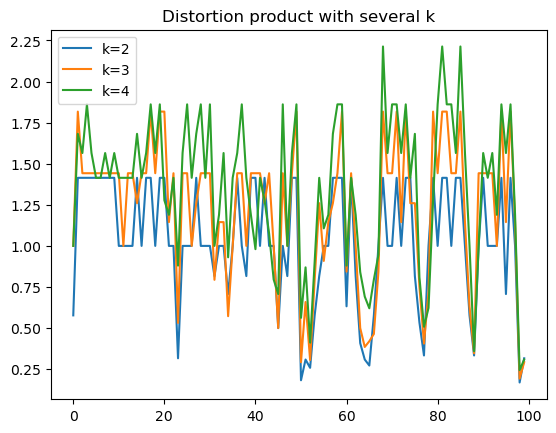

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(100), list_disto_output_2, label="k=2")
plt.plot(range(100), list_disto_output_3, label="k=3")
plt.plot(range(100), list_disto_output_4, label="k=4")
plt.legend()
plt.title("Distortion product with several k")

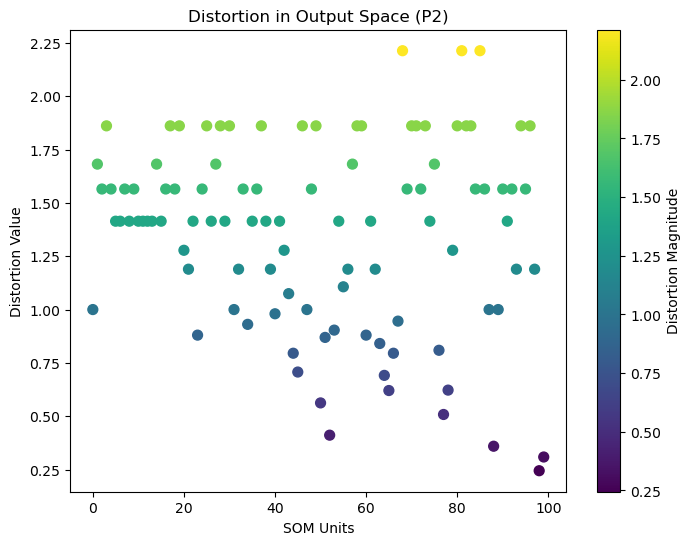

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(list_disto_output_4)), list_disto_output_4, c=list_disto_output_4, cmap='viridis', s=50)
plt.colorbar(label='Distortion Magnitude')
plt.title('Distortion in Output Space (P2)')
plt.xlabel('SOM Units')
plt.ylabel('Distortion Value')
plt.show()

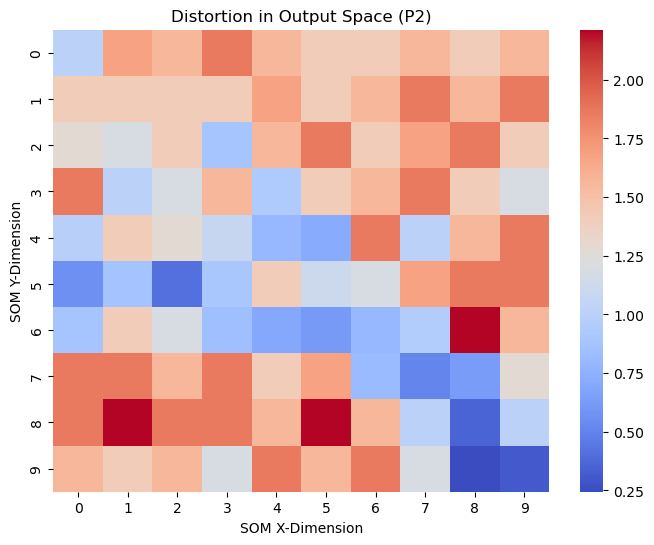

In [ ]:
disto_output_4 = np.array(list_disto_output_4)
disto_output_4 = disto_output_4.reshape(som_xdim, som_ydim)

plt.figure(figsize=(8, 6))
sns.heatmap(disto_output_4, cmap='coolwarm', annot=False)
plt.title('Distortion in Output Space (P2)')
plt.xlabel('SOM X-Dimension')
plt.ylabel('SOM Y-Dimension')
plt.show()

### $P_{3}$: Geometric mean of distortions

**Geometric mean of $P_{1}$ and $P_{2}$, capturing an overall sense of topological preservation.**

\begin{equation*}
P_{3}(j,k) = \sqrt{P_{1}(j,k) \cdot P_{2}(j,k)} = \Bigl(\prod_{l=1}^{k} Q_{1}(j,l) Q_{2}(j,l)\Bigl)^{1/2k}
\end{equation*}

In [16]:
def mean_distortion(som_distances, weights_distances, unit_i, max_k):
    p1 = distortion_input_space(som_distances, weights_distances, unit_i, max_k)
    p2 = distortion_output_space(som_distances, weights_distances, unit_i, max_k)
    return np.sqrt(p1*p2)

In [17]:
list_mean_disto_2 = []
list_mean_disto_3 = []
list_mean_disto_4 = []
list_mean_disto_9 = []
for i in range(100):
    list_mean_disto_2.append(mean_distortion(i, 2))
    list_mean_disto_3.append(mean_distortion(i, 3))
    list_mean_disto_4.append(mean_distortion(i, 4))
    list_mean_disto_9.append(mean_distortion(i, 9))

Text(0.5, 1.0, 'Mean distortion product with several k')

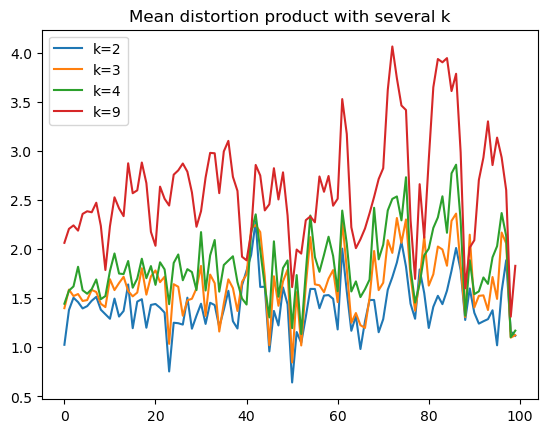

In [18]:
plt.plot(range(100), list_mean_disto_2, label="k=2")
plt.plot(range(100), list_mean_disto_3, label="k=3")
plt.plot(range(100), list_mean_disto_4, label="k=4")
plt.plot(range(100), list_mean_disto_9, label="k=9")
plt.legend()
plt.title("Mean distortion product with several k")

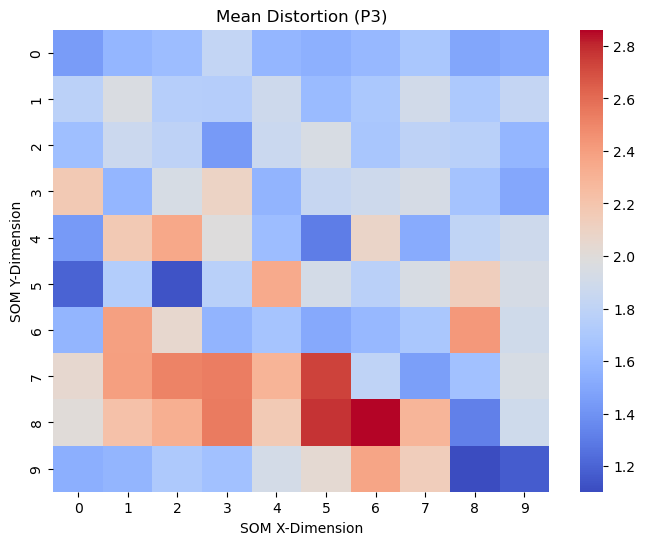

In [44]:
mean_disto_4 = np.array(list_mean_disto_4)
mean_disto_4 = mean_disto_4.reshape(som_xdim, som_ydim)
plt.figure(figsize=(8, 6))
sns.heatmap(mean_disto_4, cmap='coolwarm', annot=False)
plt.title('Mean Distortion (P3)')
plt.xlabel('SOM X-Dimension')
plt.ylabel('SOM Y-Dimension')
plt.show()

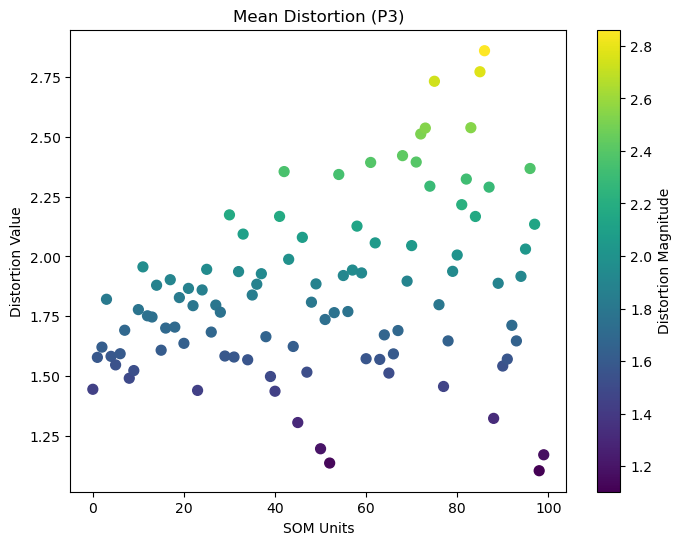

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(list_mean_disto_4)), list_mean_disto_4, c=list_mean_disto_4, cmap='viridis', s=50)
plt.colorbar(label='Distortion Magnitude')
plt.title('Mean Distortion (P3)')
plt.xlabel('SOM Units')
plt.ylabel('Distortion Value')
plt.show()

### P: Topographic product

**Overall distortion metric across all units and neighborhood orders, using the logarithmic average of $P_{3}$**

The exact formula for computing P is the following:

\begin{equation*}
  P=\frac{1}{N(N-1)} \sum_{j=1}^{N} \sum_{k=1}^{N-1} \log(P_{3}(j,k))
\end{equation*}

However, in practice, with our implementation, we can't iterate over $N-1$ orders of neighborhoods. Indeed, we are using Manhattan distances to compute the matrix of SOM grid distances, which limits the range of possible $k$. For example, with the initial example of the notebook (iris dataset with 10×10 SOM), we can't go above 11 neighbors, because some units only have 10 unique SOM distances to their neighbors. Thus, we decide to limit $k$ to this maximum number of available unique neighbors. Nevertheless, this is not very rigorous: we indeed observe (with the initial setting) that $P_{3}$ values tend to increase as $k$ increases.

In [54]:
def topographic_product(som_distances, weights_distances, max_neighb):
    p = 0
    n = som_distances.shape[0]
    for i in range(1,n):
        s = 0
        for k in range(1, max_neighb):
            s += np.log(mean_distortion(som_distances, weights_distances, i, k))
        p += s
    return p/(n*max_neighb)

Text(0.5, 1.0, 'Topographic product when increasing max_k')

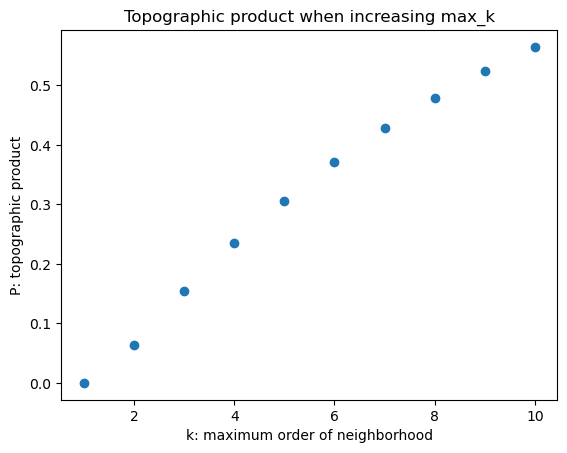

In [41]:
list_p = []
for k in range(1,11):
    list_p.append(topographic_product(som_distances, k))

plt.scatter(range(1,11), list_p)
plt.xlabel("k: maximum order of neighborhood")
plt.ylabel("P: topographic product")
plt.title("Topographic product when increasing max_k")

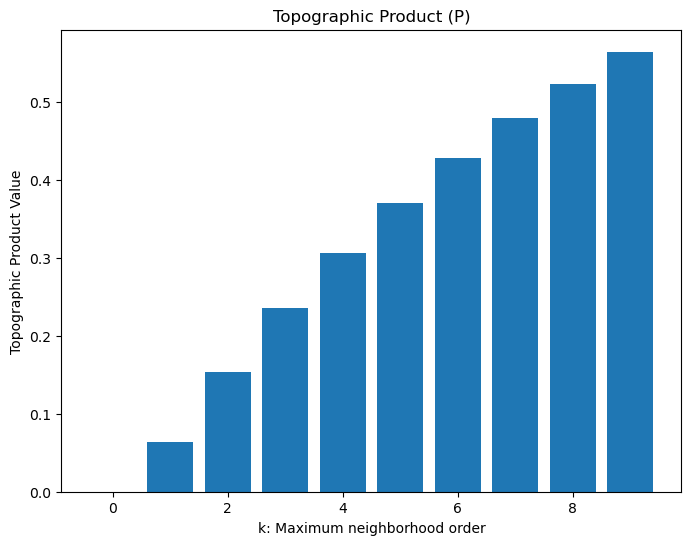

In [42]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(list_p)), list_p)
plt.title('Topographic Product (P)')
plt.xlabel('k: Maximum neighborhood order')
plt.ylabel('Topographic Product Value')
plt.show()

In [49]:
from prov.model import ProvDocument
from datetime import datetime

def log_provenance(visualization_name, parameters, output_file):
    # Initialize PROV document
    prov_doc = ProvDocument()
    # Define the process
    process = prov_doc.activity(f'process:{visualization_name}', datetime.now())

    # Document parameters
    for key, value in parameters.items():
        prov_doc.entity(f'param:{key}', {'prov:value': value})
        prov_doc.wasGeneratedBy(f'param:{key}', process)

    # Document output file
    output = prov_doc.entity(f'output:{output_file}', {'prov:type': 'File'})
    prov_doc.wasGeneratedBy(output, process)

    # Save provenance as a JSON
    with open(f"{visualization_name}_provenance.json", "w") as f:
        f.write(prov_doc.serialize(format="json"))

    return prov_doc